# Introdução

Nesse notebook são realizados os experimentos da modelagem das categorias. Com base na análise descritiva realizada préviamente em outro notebook, iremos começar os testes já partindo da utilização das variáveis identificadas como potencialmente relevantes para a previsão das categorias: `price`, `weight`, `minimum_quantity`, `express_delivery`, `title` e `concatenated_tags`. Primeiro vamos realizar modelagens de árvore mais simples, sem preocupação com otimização dos hiperparâmetros. O objetivo nessa parte é avaliar o real potencial de cada uma dessas variáveis quando consideramos todas elas simultaneamente. Para isso vamos adicionando os grupos de variáveis de forma progressiva. Primeiro começando com as variáveis que não precisam de processamento e em seguida adicionando os tópicos de título e depois os de tags.

Em seguida vamos utilizar o modelo de floresta aleatória que é uma extensão ao modelo de árvore, que tem como uma de suas principais vantagens comparado ao modelo de árvore, ser menos propício à sobrespecificação. O treinamento desse modelo será realizado através de um pipeline que integrará a modelagem com a seleção e a modelagem de tópicos para extração de novas features. Esse pipeline vai ser utilizado por um `GridsearchCV` que irá buscar combinações de parâmetros com melhor desemepnho a partir de validação cruzada.

Ao final desse notebook teremos uma estrutura de pipeline treinada e o com hiperparâmetros otimizados (escopo de busca de hiperparâmetros limitada para diminuir o tempo de treinamento).

# Imports

In [1]:
# imports do scikit-learn para a modelagem

# preprocessamento nlp e modelagem de tópicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
# modelagem de árvores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# avaliação e seleção de modelos
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# criação de pipelines
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# funções gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [3]:
from pathlib import Path
import sys

main_path = str(Path().resolve().parent)
sys.path.append(main_path)

In [4]:
# carregando as funções de preprocessamento nlp do notebook de
# análise de produto, essas funções foram adicionadas nesse modulo
from src import nlp_preprocessing

# Carregamento dos dados

Serão carregados os dados de treinamento já com o pré-processamento geral
realizado na primeira etapa de análise.

In [5]:
df_train = pd.read_pickle("../data/train_prod.pickle")
df_train.head()

,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,
7010568,761717,Caneta Personalizada Barquinho,caneta personalizada canetas personalizadas pa...,2017-07-12 16:29:08,12.260,15.0,0,30.0,116.0,11.0,Lembrancinhas
6957815,3708390,Toalha Bordada Madrinha de Consagração,toalhas lavabo lembrancinhas batizado toalha c...,2016-12-08 10:40:28,28.490,7.5,1,4.5,463.0,8.5,Lembrancinhas
10378129,8225602,Colar Best Friends Folheado 4 Partes.,biju best friends mirella flavia gabi,2017-01-24 14:32:48,40.290,13.0,0,0.0,9183.0,157.0,Bijuterias e Jóias
4658013,7043431,Azulejo Certificado Melhor Pai do Mundo,dia pais azulejos,2019-06-14 16:09:23,39.220,338.0,0,1.0,77.5,12.0,Decoração
487440,1408350,Mochila saco bailarina soldadinho de chumbo,sacolinhas festa bailarina lembrancinhas baila...,2018-02-21 16:39:27,13.175,12.5,1,32.0,1484.5,0.0,Lembrancinhas


# Avaliação inicial da extração de features para a modelagem

Nessa etapa vamos avaliar a combinação de diversos features para geração do modelo de previsão de categorias. Primeiro utilizaremos as features básicas que não precisam de pré-processamento e que foram identificadas como potencialmente relevantes para a previsão de categorias: `price`, `weight`, `express_delivery` e `minimum_quantity`.

Em seguida, vamos aplicar a modelagem de tópicos NMF para as variáveis `title` e `concatenated_tags` e testar duas combinações: features bases com tópicos de título e features bases com tópicos de tags. Por fim, todas as features vão ser reunidas para testar o modelo completo.

Nesse momento não sabemos ao certo como as previsões de classificação vão ser utilizadas. Dessa forma não conseguimos especificar com assertividade qual tipo de indicador de performance do modelo devemos maximizar. Uma solução é utilizar a métrica F1-score, que é uma média harmônica entre as métricas de precisão e recuperação (ambas com o mesmo peso). Como o problema é de multiclasse o F1-score é aplicado para cada uma das categorias. Para agregar os seis scores vamos utilizar a média ponderada pela frequência da categoria. Com isso acabamos dando mais importância para as categorias mais frequentes, o que no nosso caso, significa dar mais peso para as categorias mais buscadas de produto. Levando em consideração que essa classificação poderá ser aplicada para ajudar o ranqueamento de produtos essa propriedade da agregação de F1-scores parece fazer sentido.

Para avaliar a capacidade de generalizar do modelo, ao invés de aplicar o score para a preivão realizada em dados de treinamento, vamos utilizar a técnica de validação cruzada (com cinco dobras). Adicionalmente, vamos utilizar o `classification_report` para termos um retrato mais detalhado sobre o desempenho do modelo, porém nesse caso, nos dados de treinamento do modelo. Outro fator importante que será analisado é a contribuição de cada feature para a previsão das categorias. Essa informação estará representada em um gráfico de barras. Todos esses processos e visualizações de avaliação do modelo são excutadas pela função `test_data_modeling`.Nesse momento não sabemos ao certo como as previsões de classificação vão ser utilizadas. Dessa forma não conseguimos especificar com assertividade qual tipo de indicador de performance do modelo devemos maximizar. Uma solução é utilizar a métrica F1-score, que é uma média harmônica entre as métricas de precisão e recuperação (ambas com o mesmo peso). Como o problema é de multiclasse o F1-score é aplicado para cada uma das categorias. Para agregar os seis scores vamos utilizar a média ponderada pela frequência da categoria. Com isso acabamos dando mais importância para as categorias mais frequentes, o que no nosso caso, significa dar mais peso para as categorias mais buscadas de produto. Levando em consideração que essa classificação poderá ser aplicada para ajudar o ranqueamento de produtos essa propriedade da agregação de F1-scores parece fazer sentido.

Para avaliar a capacidade de generalizar do modelo, ao invés de aplicar o score para a preivão realizada em dados de treinamento, vamos utilizar a técnica de validação cruzada (com cinco dobras). Adicionalmente, vamos utilizar o `classification_report` para termos um retrato mais detalhado sobre o desempenho do modelo, porém nesse caso, nos dados de treinamento do modelo. Outro fator importante que será analisado é a contribuição de cada feature para a previsão das categorias. Essa informação estará representada em um gráfico de barras. Todos esses processos e visualizações de avaliação do modelo são excutadas pela função `test_data_modeling`.

Essa avaliação da modelagem terá como objetivo avaliar os dados que são utilizados. Mais especificamente vamos utilizar a função de avaliação do modelo para diversas combinações de dados. Com isso, esperamos validar a nossa seleção de features para que em uma segunda etapa possamos escolher a melhor configuração de hiperparâmetros.

Dessa forma, ao invés de buscar escolher um modelo sofisticado com hiperparâmetros cuidadosamente selecionados, aqui vamos utilizar um modelo de classificação de árvores padrão do `scikit-lear`, o `DecisionTreeClassifier`.Essa avaliação da modelagem terá como objetivo avaliar os dados que são utilizados. Mais especificamente vamos utilizar a função de avaliação do modelo para diversas combinações de dados. Com isso, esperamos validar a nossa seleção de features para que em uma segunda etapa possamos escolher a melhor configuração de hiperparâmetros.

Dessa forma, ao invés de buscar escolher um modelo sofisticado com hiperparâmetros cuidadosamente selecionados, aqui vamos utilizar um modelo de classificação de árvores padrão do `scikit-lear`, o `DecisionTreeClassifier`.

In [6]:
def gen_topics(doc: pd.Series, n_topics: int) -> pd.DataFrame:
    """Função que aplica a modelagem de tópicos para uma série de dados
    textuais

    Args:
        doc (pd.Series): série de documentos
        n_topics (int): quantidade de tópicos

    Returns:
        pd.DataFrame: dados de componentes por documentos.
    """    
    tfidf_vec = TfidfVectorizer(tokenizer=nlp_preprocessing.custom_tokenizer,
                                preprocessor=nlp_preprocessing.clean_text,
                                min_df=10,
                                max_df=0.9)
    tfidf_data = tfidf_vec.fit_transform(doc)
    topic_model = NMF(n_components=n_topics, init="random")
    topic_data = topic_model.fit_transform(tfidf_data)
    columns = [f"{doc.name}_{i}" for i in range(n_topics)]
    return pd.DataFrame(topic_data, index=doc.index, columns=columns)

In [7]:
def test_data_modeling(X_train: pd.DataFrame, y_train: pd.Series, model) -> None:
    """Gera várias visualizações para avaliar o desempenho do treinamento

    Args:
        X_train (pd.DataFrame): _description_
        y_train (pd.Series): _description_
        model (sklearn.model): _description_
    """
    
    # treinando o modelo com validação cruzada
    cv_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1,
                               scoring=make_scorer(f1_score,
                                                   average='weighted'))
    mean_score = cv_score.mean()
    std_score = cv_score.std()
    # treinando o modelo
    model.fit(X_train, y_train)
    # plotando a importância dos parâmetros
    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    importances.sort_values().plot(kind="barh")
    plt.show()
    
    # gerando o classification report
    y_pred = model.predict(X_train)
    print(classification_report(y_train, y_pred))
    # finalizando com um print, do score de treinamento e das médias e
    # desvios padrões dos scores de validação cruzada
    train_score = f1_score(y_train, y_pred, average="weighted")
    print({"train_score": train_score,
           "cv_mean_score": mean_score,
           "cv_std_score": std_score})

Por ser um modelo de árvores, que define as zonas de classificação a partir de múltiplas segmentações perpendiculares nos dados, esse modelo é adequado para representar as relações de não linearidade entre os atributos e as categorias. Por causa disso, utilizaremos as variáveis de preço e peso sem a transformação de logaritmo realizada na análise exploratória.

In [8]:
# remoção de variáveis que não vão ser utilizadas
base_train = df_train[["price", "weight", "minimum_quantity", "express_delivery"]]

# geração do dataframe com tópicos de títulos e tags
title_topics = gen_topics(df_train["title"], 6)
tags_topics = gen_topics(df_train["concatenated_tags"], 6)
# fazendo as três combinações de dados
base_title_train = base_train.join(title_topics)
base_tags_train = base_train.join(tags_topics)
full_train = base_train.join(title_topics).join(tags_topics)

# criando o dicionário que reune todos os dados criados
train_sets = [("base", base_train),
              ("base_title", base_title_train),
              ("base_tag", base_tags_train),
              ("full_train", full_train)]

base


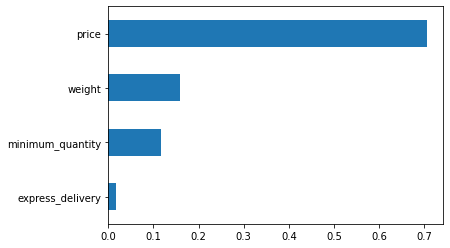

                    precision    recall  f1-score   support

              Bebê       0.51      0.49      0.50      3809
Bijuterias e Jóias       0.53      0.29      0.38       604
         Decoração       0.59      0.69      0.63      5167
     Lembrancinhas       0.76      0.88      0.82      8931
            Outros       0.35      0.05      0.09       710
       Papel e Cia       0.41      0.09      0.15      1602

          accuracy                           0.65     20823
         macro avg       0.53      0.41      0.43     20823
      weighted avg       0.62      0.65      0.62     20823

{'train_score': 0.6231711829567751, 'cv_mean_score': 0.5592526000245753, 'cv_std_score': 0.0020482620303676966}
----------------------------------------------------------------------------------------------------
base_title


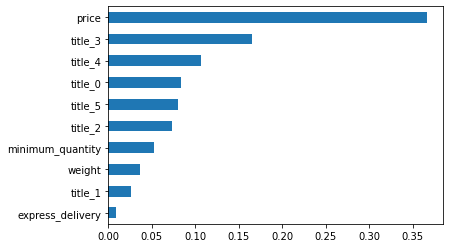

                    precision    recall  f1-score   support

              Bebê       0.77      0.70      0.73      3809
Bijuterias e Jóias       0.63      0.54      0.58       604
         Decoração       0.77      0.83      0.80      5167
     Lembrancinhas       0.84      0.92      0.88      8931
            Outros       0.50      0.27      0.35       710
       Papel e Cia       0.60      0.42      0.49      1602

          accuracy                           0.79     20823
         macro avg       0.68      0.61      0.64     20823
      weighted avg       0.77      0.79      0.78     20823

{'train_score': 0.7760995041630832, 'cv_mean_score': 0.7219762965163306, 'cv_std_score': 0.007354553567046953}
----------------------------------------------------------------------------------------------------
base_tag


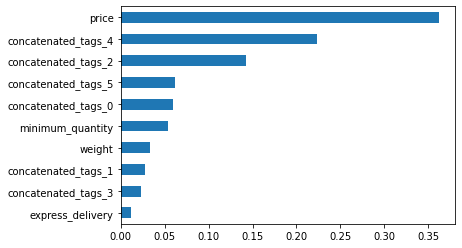

                    precision    recall  f1-score   support

              Bebê       0.81      0.75      0.78      3809
Bijuterias e Jóias       0.66      0.53      0.59       604
         Decoração       0.78      0.84      0.81      5167
     Lembrancinhas       0.83      0.91      0.87      8931
            Outros       0.48      0.26      0.34       710
       Papel e Cia       0.58      0.38      0.46      1602

          accuracy                           0.79     20823
         macro avg       0.69      0.61      0.64     20823
      weighted avg       0.78      0.79      0.78     20823

{'train_score': 0.7783660388153286, 'cv_mean_score': 0.7318011164615864, 'cv_std_score': 0.006849633395680611}
----------------------------------------------------------------------------------------------------
full_train


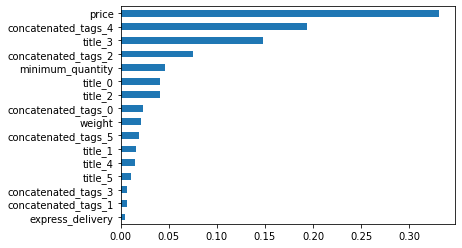

                    precision    recall  f1-score   support

              Bebê       0.81      0.77      0.79      3809
Bijuterias e Jóias       0.63      0.58      0.61       604
         Decoração       0.81      0.84      0.83      5167
     Lembrancinhas       0.85      0.92      0.88      8931
            Outros       0.53      0.26      0.35       710
       Papel e Cia       0.59      0.45      0.51      1602

          accuracy                           0.80     20823
         macro avg       0.70      0.64      0.66     20823
      weighted avg       0.79      0.80      0.80     20823

{'train_score': 0.7958635161008878, 'cv_mean_score': 0.7417706296050438, 'cv_std_score': 0.006464998615490081}
----------------------------------------------------------------------------------------------------


In [9]:
model = DecisionTreeClassifier(random_state=23, min_samples_leaf=0.001)
y_train = df_train["category"]

for name, data in train_sets:
    print(name)
    test_data_modeling(data, y_train, model)
    print("-"* 100)

Como é possível observar, conforme vamos aumentando a quantidade de atributos o desempenho do modelo também aumenta. Isso vale tanto para os scores calculados com os dados de treinamento quanto para as médias dos scores obtidos pela validação cruzada. Isso é um indício de que mesmo com o crescimento da quantidade de atributos não estamos incorrendo em sobrespecificação.

Dos quatro atributos base identificados na análise exploratória, apenas `express_delivery` teve desemepenho abaixo do esperado. É provável que grande parte da variabilidade das categorias que poderia ser explicada por essa variável já foi explicada por outras. Com isso faz sentido não dar prosseguimento à utilização desse atributo na modelagem final.

Quando adicionamos os tópicos dos títulos ou das tags às variáveis base, obtivemos um incremento considerável no score médio de validação cruzada. Porém, esse incremento não foi da mesma forma quando utilizamos todos os dados (em comparação com os atributos base e algum conjunto de atributos de tópicos). Isso deve ter ocorrido por conta de um certa duplicidade nas informações contidas nos tópicos de títulos e tags. 

Concluindo essa parte, constatamos a importância das features `price`, `weight` e `minimum_quantiy`. Também conseguimos identificar que os tópicos extraídos das variáveis `title` e `concatenated_tags` são úteis para prever `category`. O que não foi possível verificar é qual a quantidade de tópicos mais adequada para a modelagem. Esse hiperparâmetro será definido na próxima parte, onde além destes iremos buscar otimizar outros do modelo.

# Pipeline de Treinamento e GridSearch

A escolha da melhor combinação de hiperâmetros será realizada pela `GridSearchCV`. Essa classe treina combina a validação cruzada à buscas extensivas por combinações de hiperparâmetros. Ao percorrer todas as combinações e para cada dobra da validação cruzada, treina o modelo e obtem os scores nos dados de teste (e de treinamento se assim for selecionado).

Ao invés de utilizar o modelo de árvore de decisão, como estamos nos preocupando em melhorar o score do modelo vamos utilizar uma extensão da modelagem de árvore que combina diversos modelos de árvores por meio de **Baggin**, um modelo de `RandomForestClassifier`. Com isso, são treinados diversos modelos de árvore, cada qual utilizando uma amostra dos dados (amostragem com repetição). O resultado dos diversos modelos é agregada para gerar a previsão final. No caso do modelo de classificação, isso significar escolher a moda.

Uma das grandes vantagens de escolher o modelo de Floresta é que ele concilia o viés dos modelos de árvore com a baixa variância por conta da utilização de **Bagging**. O que no caso, acaba mitigando um dos principais problemas de modelagem de árvore.

Para simplificar o processo de treinamento e garantir que tanto os processos de pré-processamento, e geração de novos atributos sejam aplicados de forma consistente tanto para o treinamento quanto para a testagem do modelo, incuíremos todas essas etapas em um `Pipeline`. É esse objeto que iremos utilizar como "modelo" para a busca do melhor conjunto de parâmetros com `GridSearchCV`.

In [16]:
def gen_topic_transformer(column_name: str) -> Pipeline:
    """Gera um pipeline de geração de tópicos NMF a partir de um nome de coluna

    Args:
        column_name (str): nome da feature utilizada

    Returns:
        Pipeline: pipeline de tópicos NMF
    """    
    return Pipeline(steps=[
        ("selector", FunctionTransformer(lambda x: x[column_name])),
        ("tfidf", TfidfVectorizer(tokenizer=nlp_preprocessing.custom_tokenizer,
                                  preprocessor=nlp_preprocessing.clean_text,
                                  min_df=10,
                                  max_df=0.9)),
        ("nmf", NMF(init="random", max_iter=1000, random_state=23))
    ])

In [17]:
# criando o FeatureUnion que irá gerar os dados para a modelagem
cols = ["price", "weight", "minimum_quantity"]
features_pipelines = FeatureUnion([
    ("title", gen_topic_transformer("title")),
    ("tags", gen_topic_transformer("concatenated_tags")),
    ("selector", FunctionTransformer(lambda x: x[cols]))
])
# criando o pipeline completo
pipeline = Pipeline([
    ("preprocessing", features_pipelines),
    ("rf", RandomForestClassifier(random_state=23))
])

A busca pelos melhores parâmetros envolverá selecionar uma combinação entre os valores especificados abaixo. Serão testados vários valores de quantidades de tópicos, tanto para os de `title` quanto para os de `concatenated_tags`. Para regularizar o modelos de árvore e eviar a sobrespecifação do modelo, serão testados valores para profundidade máxima das árvores. Outro valor que contribui para a regularizção é aumentar a quatidade de árvores, aumentando a estabilidade do modelo.

In [ ]:
# criando o grid onde a busca será realizada para encontrar a melhor combinação
# de hiperparâmetros estamos fazendo a busca pela quantidade de componentes
# pela quantidade de estimadores de uma floresta e pela profundida
# quanto maior a profundidadae mais complexa e maior a possibilidade de
# sobrespecificar.
params_grid = {"preprocessing__title__nmf__n_components": [10, 25, 50],
               "preprocessing__tags__nmf__n_components": [10, 25, 50],
               "rf__n_estimators": [500, 1000, 1500],
               "rf__max_depth": [10, 15, 20, 25, 50]}

In [19]:
grid_rf = GridSearchCV(pipeline, params_grid, cv=5, verbose=1)
grid_rf.fit(df_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function gen_topic_transformer.<locals>.<lambda> at 0x000001DA9A2950D0>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_df=0.9,
                                                                                                         min_df=10,
                                                                                                         preprocessor=<function clean_text at 0x000001DA97640A60>,
                                                          

Pelo `classification_report` utilizando os dados de treinamento obtivemos score máximo para todas as classes. Isso é um fortíssimo indicativo de que estamos incorrendo em sobrespecificação. Isto, é modelo se adaptou tão perfeitamente aos de treinamento que muito provavelmente deve ter aprendido também as combinações de atributos que apesar de estarem representadas nos dados de treinamento não refletem o processo gerador genérico das classes.

In [22]:
# avaliando o melhor modelo utilizando dados de treinamento
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(df_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       1.00      1.00      1.00      3809
Bijuterias e Jóias       1.00      1.00      1.00       604
         Decoração       1.00      1.00      1.00      5167
     Lembrancinhas       1.00      1.00      1.00      8931
            Outros       1.00      1.00      1.00       710
       Papel e Cia       1.00      1.00      1.00      1602

          accuracy                           1.00     20823
         macro avg       1.00      1.00      1.00     20823
      weighted avg       1.00      1.00      1.00     20823



Pelos dados do valor médio do F1-score nos dados de teste durantes as validações cruzadas, vemos que o aumento da quantidade de componentes e o tamanho da árvores são determinantes para o aumento da perfomance do modelo. Isso é um resultado esperado, quanto maior forem esses valores maior a quantidade de informações (possibilidades para adaptação) e maior será a capacidade do modelo de se adaptar aos dados. De certo modo, só conseguimos extrair maior proveito da maior quantidade de componentes quando possibilitamos a geração de árvores maiores.

Entretanto esse ganho de perforance não é uniforme para todos os valores dos hiperparâmetros. Conforme a quantidade de componentes e tamanho da árvore aumentam sua capacidade de melhorar o modelo diminuem. De certo modo, só conseguimos extrair maior proveito da maior quantidade de componentes. O incremento é muito pequeno quando passamos de uma profundida máxima de 25 para 50. O mesmo ocorre quando alteramos a quantidade máxima de
tópicos de 50 para 100.

Com isso, não se jusitifica aumentar a complexidade dos modelos. Soma-se a isso a evidência de sobreajuste com F1-Score de 100% para os dados de treinamento. Dessa forma, ao invés de escolher o modelo de melhor desempenho, talvez seja mais interessante escolher um que seja um pouco inferior, mas que tenham menos riscos de sobreajustes.

In [61]:
results = pd.DataFrame(grid_rf.cv_results_["params"])
results["mean_test_score"] = grid_rf.cv_results_["mean_test_score"]
results["std_test_score"] = grid_rf.cv_results_["std_test_score"]
results["n_components"] = (results["preprocessing__tags__nmf__n_components"] +
                           results["preprocessing__title__nmf__n_components"])
results

,preprocessing__tags__nmf__n_components,preprocessing__title__nmf__n_components,rf__max_depth,rf__n_estimators,mean_test_score,std_test_score,n_components
0,10,10,10,500,0.799260,0.007561,20
1,10,10,10,1000,0.799932,0.007045,20
2,10,10,10,1500,0.799500,0.007165,20
3,10,10,15,500,0.833165,0.005207,20
4,10,10,15,1000,0.833501,0.004684,20
...,...,...,...,...,...,...,...
130,50,50,25,1000,0.854247,0.004056,100
131,50,50,25,1500,0.853623,0.003742,100
132,50,50,50,500,0.860634,0.004582,100
133,50,50,50,1000,0.860394,0.004554,100


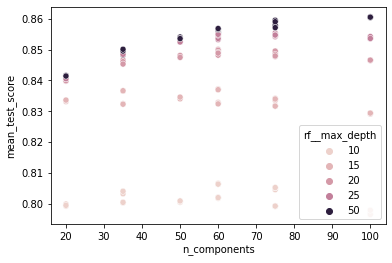

In [68]:
(sns.scatterplot(data=results,
                 x="n_components",
                 y="mean_test_score",
                 hue="rf__max_depth"))
plt.show()

Já para o impacto da quantidade de estimadores sobre o desemepenho, vemos que seu impacto é desprezível.

In [69]:
results.groupby("rf__n_estimators")["mean_test_score"].mean()

rf__n_estimators
500     0.837396
1000    0.837490
1500    0.837428
Name: mean_test_score, dtype: float64

Com base nesses resultados um novo experimento será realizado. Focalizando melhor nas features que podem trazer resultado e adicionando novas features para a busca.

Além de utilizar o hiperparâmetro de tamanho máximo das árvores, agora vamos utilizar o tamanho mínimo de amostra em cada folha da árvore. Esse é um hiperparâmetro completar ao tamanho máximo da árvore para controlar a regularização imposta à modelagem de árvores. Sendo que, quanto maior o tamanho máximo das árvores menor a regularização imposta ao modelo, e quanto maior a amostra mínima nas folhas maior a regularização.

In [81]:
# criando o grid onde a busca será realizada para encontrar a melhor combinação
# de hiperparâmetros estamos fazendo a busca pela quantidade de componentes
# pela quantidade de estimadores de uma floresta e pela profundida
# quanto maior a profundidadae mais complexa e maior a possibilidade de
# sobrespecificar.
params_grid = {"preprocessing__title__nmf__n_components": [10, 25],
               "preprocessing__tags__nmf__n_components": [10, 25],
               "rf__n_estimators": [500],
               "rf__max_depth": [15, 20, 25],
               "rf__min_samples_leaf": [0.001, 0.0005, 0.0001]}

new_grid_rf = GridSearchCV(pipeline, params_grid, cv=5, verbose=1,
                           return_train_score=True)
new_grid_rf.fit(df_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        FeatureUnion(transformer_list=[('title',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function gen_topic_transformer.<locals>.<lambda> at 0x000001DA9A2950D0>)),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(max_df=0.9,
                                                                                                         min_df=10,
                                                                                                         preprocessor=<function clean_text at 0x000001DA97640A60>,
                                                          

Pelo resultado vemos que agora, com excessão da precisão para a categoria **Outros** não maximizamos a métrica de avaliação. Apesar disso, o resultado é muito próximo de 100% para quase todas as outras métricas. O que ainda pode ser um sinal de alerta.

In [82]:
# avaliando o melhor modelo utilizando dados de treinamento
best_model = new_grid_rf.best_estimator_
y_pred = best_model.predict(df_train)
print(classification_report(y_true=y_train, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       0.97      0.93      0.95      3809
Bijuterias e Jóias       0.99      0.90      0.94       604
         Decoração       0.95      0.97      0.96      5167
     Lembrancinhas       0.93      0.99      0.96      8931
            Outros       1.00      0.70      0.82       710
       Papel e Cia       0.98      0.81      0.89      1602

          accuracy                           0.95     20823
         macro avg       0.97      0.88      0.92     20823
      weighted avg       0.95      0.95      0.95     20823



Por conta do aumento da regularização e na redução da quantidade de atributos, vemos uma redução na performance do modelo. A despeito do pior desemepenho vamos manter esse último modelo tendo em vista o menor risco de sobreespecificação.

In [83]:
results = pd.DataFrame(new_grid_rf.cv_results_["params"])
results["mean_test_score"] = new_grid_rf.cv_results_["mean_test_score"]
results["std_test_score"] = new_grid_rf.cv_results_["std_test_score"]
results["n_components"] = (results["preprocessing__tags__nmf__n_components"] +
                           results["preprocessing__title__nmf__n_components"])
results.head()

,preprocessing__tags__nmf__n_components,preprocessing__title__nmf__n_components,rf__max_depth,rf__min_samples_leaf,rf__n_estimators,mean_test_score,std_test_score,n_components
0,10,10,15,0.0010,500,0.807472,0.006019,20
1,10,10,15,0.0005,500,0.816501,0.005385,20
2,10,10,15,0.0001,500,0.829707,0.005259,20
3,10,10,20,0.0010,500,0.808769,0.005692,20
4,10,10,20,0.0005,500,0.818518,0.005213,20


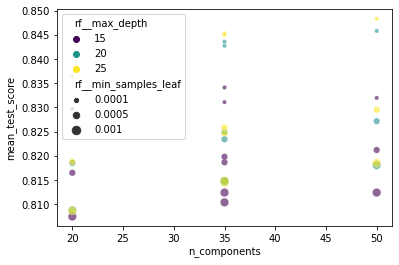

In [84]:
(sns.scatterplot(data=results,
                 x="n_components",
                 y="mean_test_score",
                 hue="rf__max_depth",
                 size="rf__min_samples_leaf",
                 alpha=0.6,
                 palette="viridis"))
plt.show()

Tendo esse modelo escolhido iremos avaliá-lo sobre os dados de teste, separados e salvos no primeiro notebook.

In [102]:
# avaliando o melhor modelo utilizando dados de teste
df_test = pd.read_pickle("../data/test_prod.pickle")
y_test = df_test["category"]
y_pred = best_model.predict(df_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

                    precision    recall  f1-score   support

              Bebê       0.88      0.79      0.83      1633
Bijuterias e Jóias       0.96      0.76      0.85       259
         Decoração       0.83      0.91      0.87      2215
     Lembrancinhas       0.85      0.96      0.90      3828
            Outros       0.85      0.30      0.44       304
       Papel e Cia       0.86      0.48      0.61       686

          accuracy                           0.85      8925
         macro avg       0.87      0.70      0.75      8925
      weighted avg       0.85      0.85      0.84      8925



Em seguida vamos salvar os parâmetros para no futuro treinar o modelo utilizando todos os dados, testes e treinamento. Com maior quantidade de dados é esperado que o desempenho do modelo seja melhor. Uma vez que não iremos mais modificar os hiperparâmetros e etapas de pré-processamento não precisamos mais manter os dados de teste.

In [187]:
title_nmf_params = best_model.named_steps["preprocessing"].transformer_list[0][1][2].get_params()
tags_nmf_params = best_model.named_steps["preprocessing"].transformer_list[1][1][2].get_params()
rf_params = best_model.named_steps["rf"].get_params()

params_dict = {"title_nmf": title_nmf_params,
               "tags_nmf": tags_nmf_params,
               "rf_category_clf": rf_params}

for name, params in params_dict.items():
    file_path = f"..\config\{name}.json"
    with open(file_path, "w") as file:
        json.dump(params, file, indent=4)